# Classificador de Galáxias

### *Dataset*: https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from ipywidgets import interact
import seaborn as sns
import math

from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Reshape, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError 
from tensorflow.keras.models import load_model
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_xception
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_input_resnet

## Funções e classes utilizadas

In [ ]:
# Função para treinar modelos

def train_model(model, lr, epochs, ds_train, ds_val):
  model.compile(loss='mean_squared_error', metrics=['RootMeanSquaredError'], optimizer=Adam(learning_rate=lr))

  callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=1e-5), 
               EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=7, verbose=1, mode="min")]

  start = time.time()
  history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks)
  end = time.time()

  plots(history)
  print("\n\nTreinamento durou {:.2f} horas.".format((end-start)/3600))

  return history

In [ ]:
# Função para preparar o tf.data.Dataset

def create_dataset(df, img_size, batch_size):
  paths = df['path']
  labels = df.loc[:, ~df.columns.isin(['path', 'GalaxyID'])]
  ds = tf.data.Dataset.from_tensor_slices((paths, labels))
  ds = ds.map(lambda x, y: (tf.io.read_file(x), y))
  ds = ds.map(lambda x, y: (tf.io.decode_jpeg(x, channels=3), y))
  ds = ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
  ds = ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
#Plots para treinamento

def plots(history, xlim=None, ylim=None):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.yscale('log')
  plt.grid(which='both');

  plt.subplot(1, 2, 2)
  plt.plot(history['root_mean_squared_error'], '.-', label='Root Mean Squared Error - Train')
  plt.xlabel('Epochs');
  if 'val_root_mean_squared_error' in history.keys():
    plt.plot(history['val_root_mean_squared_error'], '.-', label='Root Mean Squared Error - Validation')
    plt.title(f"Validation Root Mean Squared Error: {np.max(history['val_root_mean_squared_error']):.1%} (best) | {history['val_root_mean_squared_error'][-1]:.1%} (last)");
  plt.legend();
  plt.xlim(xlim);
  plt.ylim(ylim);
  plt.grid();

## Carregando Datasets

In [ ]:
!unzip -o drive/MyDrive/colab/Projeto_final/images_training_rev1.zip> /dev/null

In [ ]:
df = pd.read_csv("drive/MyDrive/colab/Projeto_final/training_solutions_rev1.zip", compression='zip')

In [ ]:
vgg_path = f'gdrive/vgg/'
xception_path = f'gdrive/xception'
resnet_path = f'gdrive/resnet'

if not os.path.exists('gdrive'):
  os.symlink('drive/MyDrive/colab', 'gdrive')

In [ ]:
Galaxy_ID_list = []
for Galaxy_ID in df['GalaxyID']:
  Galaxy_ID_list.append('images_training_rev1' +'/'+str(Galaxy_ID)+'.jpg');
df['path'] = Galaxy_ID_list

In [ ]:
# Separação entre treino, teste e validação
df_train, df_test = train_test_split(df, test_size = 0.4, shuffle=True)
df_test, df_val = train_test_split(df_test, test_size = 0.5)

In [ ]:
img_size = (160, 160) 
batch_size = 64

ds_train = create_dataset(df_train, img_size, batch_size);
ds_test  = create_dataset(df_test, img_size, batch_size);
ds_val   = create_dataset(df_val, img_size, batch_size);

In [ ]:
input_shape = img_size + (3,)

## Exploratory Data Analysis

In [ ]:
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6,path
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512,images_training_rev1/100008.jpg
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000,images_training_rev1/100023.jpg
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,images_training_rev1/100053.jpg
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000,images_training_rev1/100078.jpg
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,images_training_rev1/100090.jpg


In [ ]:
print("Este Dataset contém " + str(df.shape[0]) + " amostras e " + str(df.shape[1]-2) + " classes.")
print("Treino: " + str(df_train.shape[0]) + " amostras.")
print("Validação: " + str(df_val.shape[0]) + " amostras.")
print("Teste: " + str(df_test.shape[0]) + " amostras.")

Este Dataset contém 61578 amostras e 37 classes.
Treino: 36946 amostras.
Validação: 12316 amostras.
Teste: 12316 amostras.


### EDA no conjunto de treinamento

In [ ]:
df_train.describe()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
count,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000,...,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000,36946.000000
mean,549949.838575,0.433169,0.541553,0.025278,0.105972,0.435580,0.102265,0.333316,0.215232,0.220348,...,0.032821,0.091205,0.084176,0.039851,0.015287,0.094303,0.017608,0.007853,0.007008,0.073172
std,259267.239299,0.282565,0.295451,0.037694,0.212095,0.301220,0.176760,0.247423,0.285425,0.179670,...,0.098055,0.144881,0.139786,0.099044,0.051767,0.193760,0.067156,0.039123,0.037869,0.107019
min,100023.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326753.250000,0.178692,0.280862,0.000000,0.000000,0.169538,0.000000,0.124093,0.000000,0.072627,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550621.500000,0.417626,0.557605,0.014995,0.000000,0.393894,0.000000,0.289674,0.092900,0.183923,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,773948.500000,0.678701,0.808021,0.034421,0.084249,0.692446,0.134337,0.516451,0.329008,0.339182,...,0.000000,0.145240,0.127842,0.030673,0.000000,0.100136,0.000000,0.000000,0.000000,0.127333
max,999967.000000,1.000000,1.000000,0.876458,1.000000,1.000000,1.000000,1.000000,1.000000,0.925311,...,0.901991,0.949733,0.850616,0.996952,0.886363,1.000000,0.975913,0.957000,0.919000,0.753082


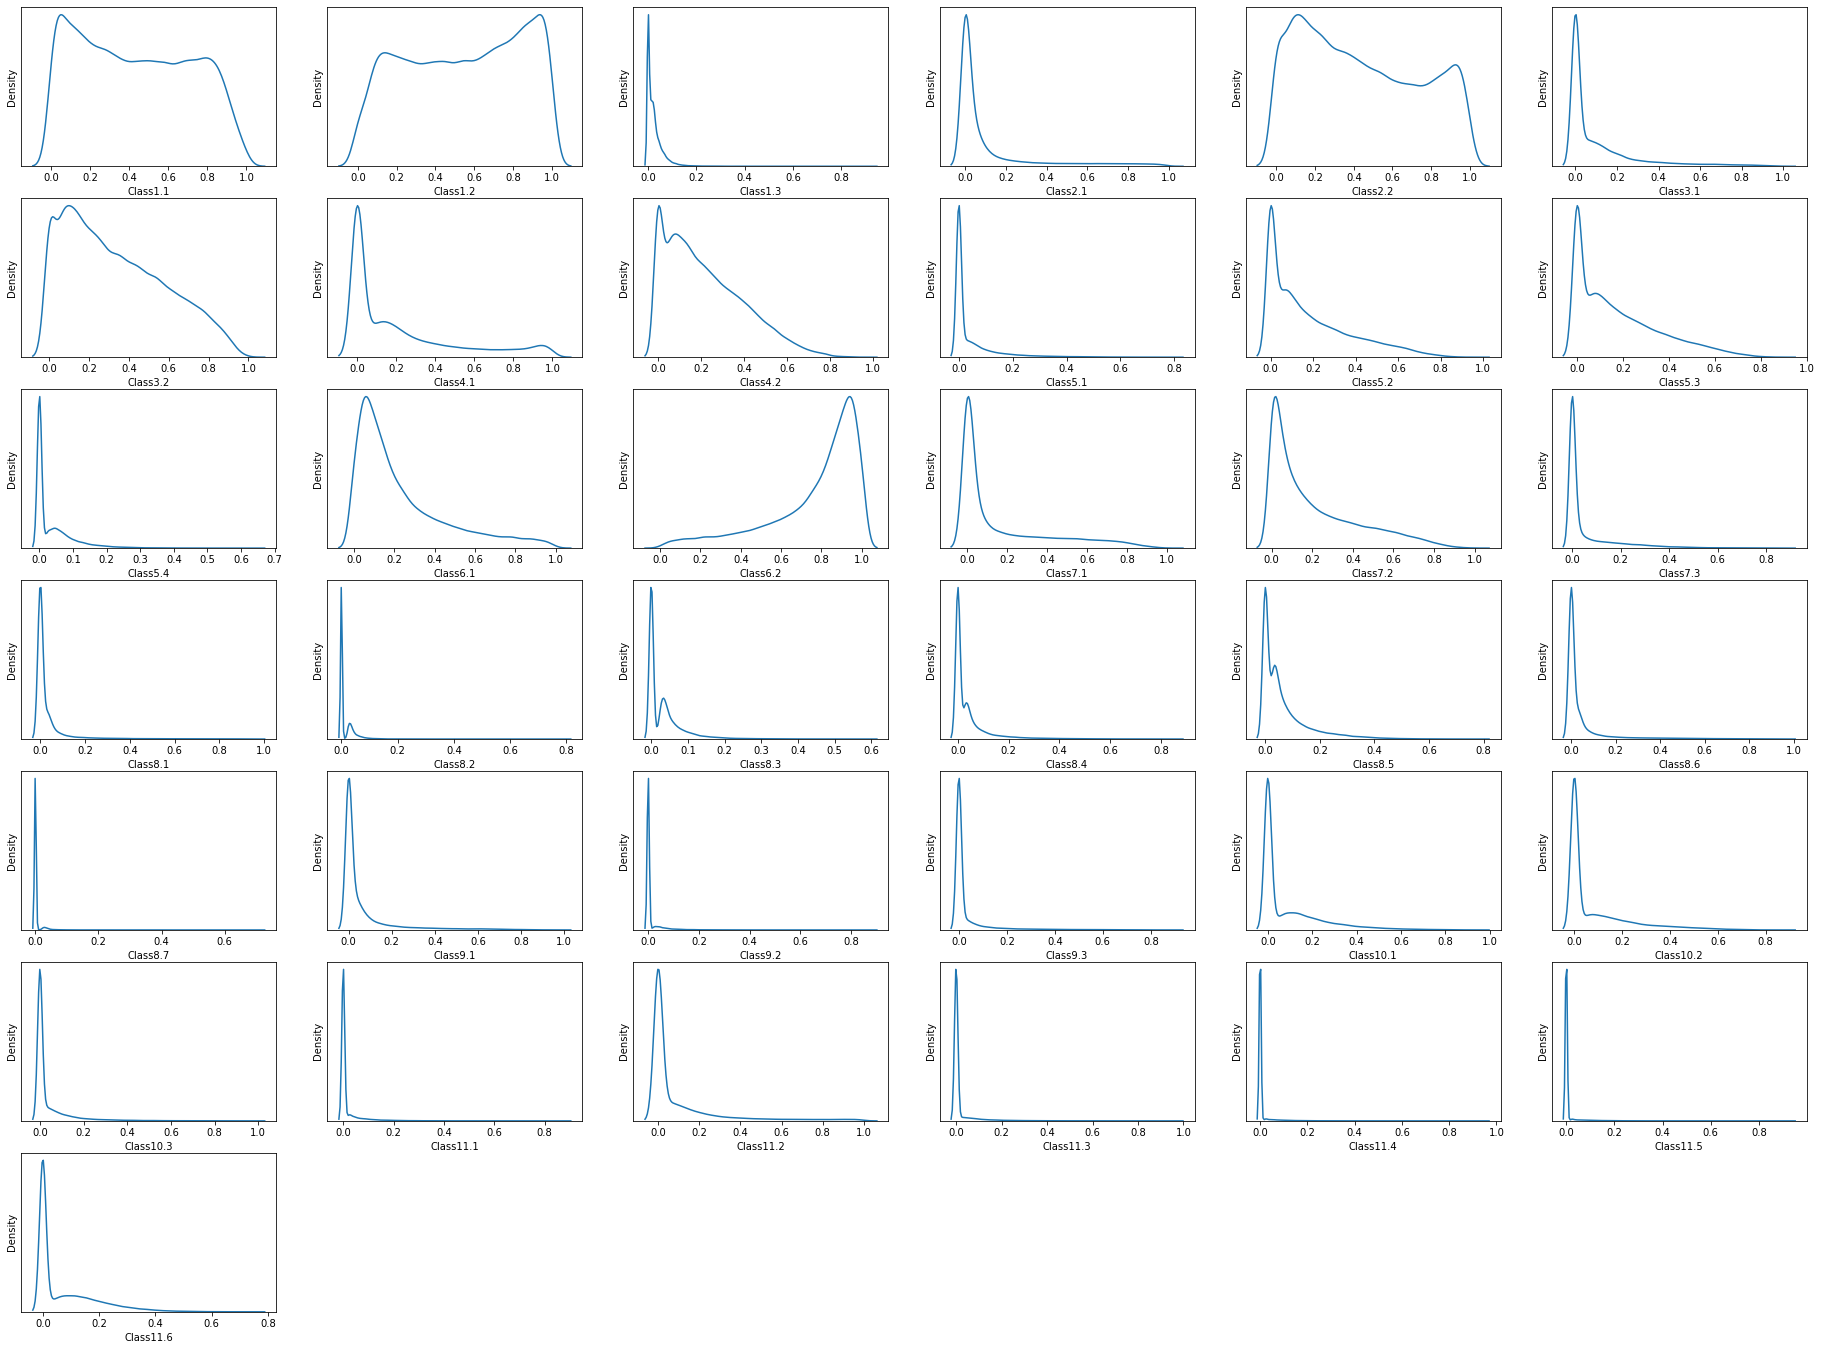

In [ ]:
#Algumas densidades de probabilidades usando estimativa de densidade de Kernel não paramétrica.

plt.figure(figsize=(32, 24))

for i in range(37):
  plt.subplot(7, 6, i+1)
  sns.kdeplot(df.iloc[:,i+1])
  plt.tick_params(labelleft=False, left=False)

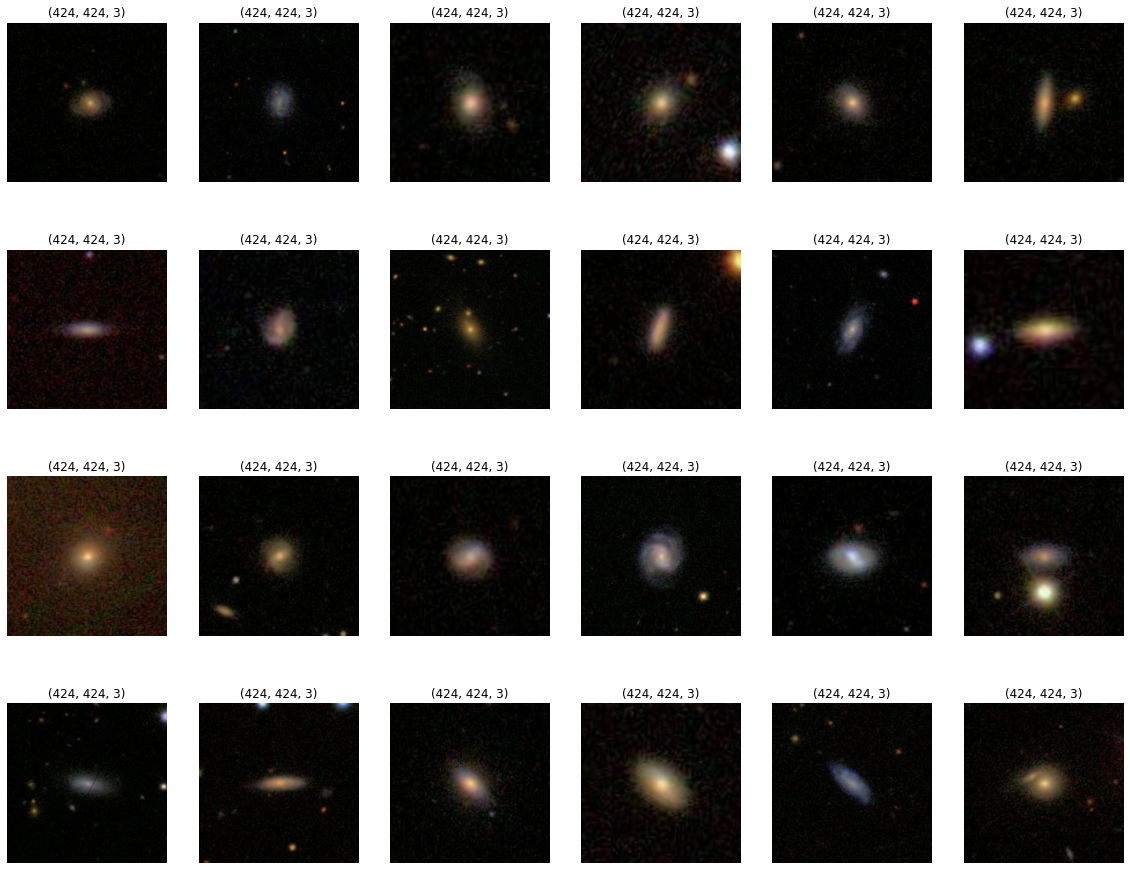

In [ ]:
# Algumas visualizações

plt.figure(figsize=(20, 16))
for i in range(24):
  #for j in range(2):
  plt.subplot(4, 6, i+1)
  img = plt.imread(df_train['path'].iloc[i])
  plt.title(img.shape)
  plt.imshow(img)
  plt.axis('off')

## Treinamento dos modelos

### VGG 16

Epoch 1/50
578/578 [==============================] - 303s 520ms/step - loss: 0.0232 - root_mean_squared_error: 0.1522 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137 - lr: 1.0000e-04
Epoch 2/50
578/578 [==============================] - 299s 518ms/step - loss: 0.0133 - root_mean_squared_error: 0.1155 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039 - lr: 1.0000e-04
Epoch 3/50
578/578 [==============================] - 299s 517ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001 - lr: 1.0000e-04
Epoch 4/50
578/578 [==============================] - 299s 517ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979 - lr: 1.0000e-04
Epoch 5/50
578/578 [==============================] - 297s 515ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0950 - lr: 1.0000e-04
Epoch 6/50
578/578 [===============

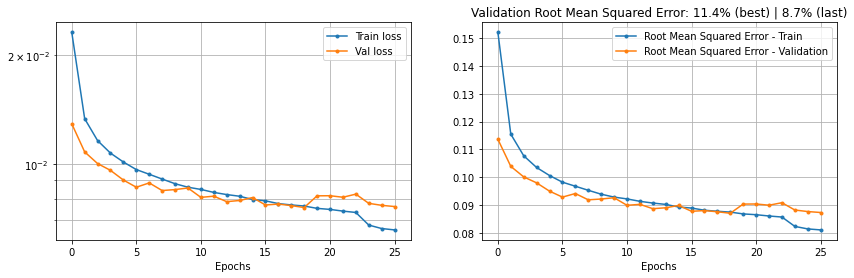

In [ ]:
vgg_model = VGG16(include_top=False, input_shape=input_shape, pooling='avg')
vgg_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input_vgg16(i)
x = RandomFlip("horizontal_and_vertical")(x)
x = RandomRotation(0.2)(x)
x = RandomZoom(height_factor=0.3, width_factor=0.3)(x)
x = RandomContrast(0.03)(x)
x = vgg_model(x, training=False)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(37, activation='sigmoid')(x)

vgg_model = Model(i, x)

vgg_history = train_model(vgg_model, 1e-4, 50, ds_train, ds_val);

In [ ]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 random_flip (RandomFlip)    (None, 160, 160, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 160, 160, 3)      0         
 tion)                                                           
                                                           

In [ ]:
#Salvar Modelo VGG
vgg_model.save(vgg_path)

INFO:tensorflow:Assets written to: gdrive/vgg/assets


INFO:tensorflow:Assets written to: gdrive/vgg/assets


### Xception

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/50
578/578 [==============================] - 439s 721ms/step - loss: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038 - lr: 1.0000e-04
Epoch 2/50
578/578 [==============================] - 415s 718ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001 - lr: 1.0000e-04
Epoch 3/50
578/578 [==============================] - 414s 717ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976 - lr: 1.0000e-04
Epoch 4/50
578/578 [==============================] - 414s 716ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0945 - lr: 1.0000e-04
Epoch 5/50
578/578 [==============================] - 414s 717ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0088 - val_root_mean_squared_e

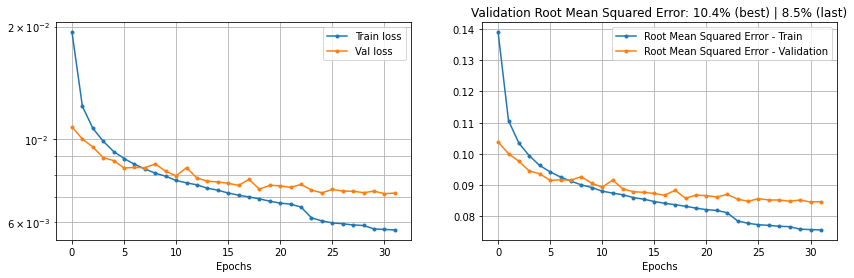

In [ ]:
xception_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
xception_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input_xception(i)
x = RandomFlip("horizontal_and_vertical")(x)
x = RandomRotation(0.2)(x)
x = RandomZoom(height_factor=0.3, width_factor=0.3)(x)
x = RandomContrast(0.03)(x)
x = xception_model(x, training=False)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(37, activation='sigmoid')(x)

xception_model = Model(i, x)

xception_history = train_model(xception_model, 1e-4, 50, ds_train, ds_val);

In [ ]:
xception_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 random_flip (RandomFlip)    (None, 160, 160, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 160, 160, 3)      0         
 tion)                                                           
                                                             

In [ ]:
#Salvar modelo Xception
xception_model.save(xception_path)

INFO:tensorflow:Assets written to: gdrive/xception/assets


INFO:tensorflow:Assets written to: gdrive/xception/assets


### Resnet

Epoch 1/50
578/578 [==============================] - 214s 359ms/step - loss: 0.0222 - root_mean_squared_error: 0.1489 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095 - lr: 1.0000e-04
Epoch 2/50
578/578 [==============================] - 206s 356ms/step - loss: 0.0132 - root_mean_squared_error: 0.1147 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0995 - lr: 1.0000e-04
Epoch 3/50
578/578 [==============================] - 206s 356ms/step - loss: 0.0115 - root_mean_squared_error: 0.1071 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958 - lr: 1.0000e-04
Epoch 4/50
578/578 [==============================] - 206s 356ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927 - lr: 1.0000e-04
Epoch 5/50
578/578 [==============================] - 206s 356ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926 - lr: 1.0000e-04
Epoch 6/50
578/578 [===============

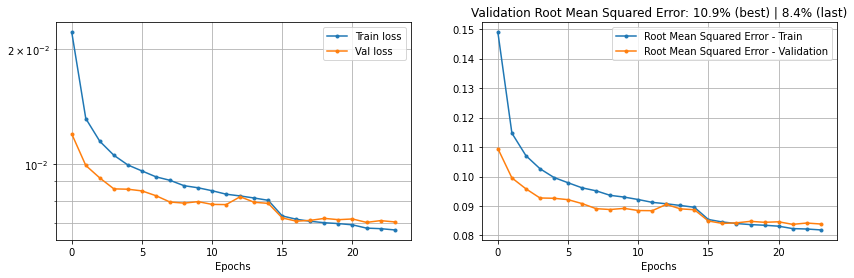

In [ ]:
resnet_model = ResNet50V2(include_top=False, input_shape=input_shape, pooling='avg')
resnet_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input_resnet(i)
x = RandomFlip("horizontal_and_vertical")(x)
x = RandomRotation(0.2)(x)
x = RandomZoom(height_factor=0.3, width_factor=0.3)(x)
x = RandomContrast(0.03)(x)
x = resnet_model(x, training=False)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(37, activation='sigmoid')(x)

resnet_model = Model(i, x)

resnet_history = train_model(resnet_model, 1e-4, 50, ds_train, ds_val);

In [ ]:
resnet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 random_flip_2 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 160, 160, 3)      0         
 tation)                                                         
                                                           

In [ ]:
#Salvar modelo Resnet
resnet_model.save(resnet_path)

INFO:tensorflow:Assets written to: gdrive/resnet/assets


INFO:tensorflow:Assets written to: gdrive/resnet/assets


## Avaliação no conjunto de teste

In [ ]:
trained_vgg_model = load_model(vgg_path)

print("VGG 16\n")
print("RMSE Train:")
vgg_score_train = trained_vgg_model.evaluate(ds_train, batch_size=batch_size)
print("RMSE Validation: ")
vgg_score_val = trained_vgg_model.evaluate(ds_val, batch_size=batch_size)
print("RMSE Test: ")
vgg_score_test = trained_vgg_model.evaluate(ds_test, batch_size=batch_size)

VGG 16

RMSE Train:
578/578 [==============================] - 58s 81ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848
RMSE Validation: 
193/193 [==============================] - 16s 83ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847
RMSE Test: 
193/193 [==============================] - 16s 82ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850


In [ ]:
trained_xception_model = load_model(xception_path)

print("Xception\n")
print("RMSE Train:")
xception_score_train = trained_xception_model.evaluate(ds_train, batch_size=batch_size)
print("RMSE Validation: ")
xception_score_val = trained_xception_model.evaluate(ds_val, batch_size=batch_size)
print("RMSE Test: ")
xception_score_test = trained_xception_model.evaluate(ds_test, batch_size=batch_size)

Xception

RMSE Train:
578/578 [==============================] - 49s 81ms/step - loss: 0.0064 - root_mean_squared_error: 0.0797
RMSE Validation: 
193/193 [==============================] - 16s 82ms/step - loss: 0.0063 - root_mean_squared_error: 0.0796
RMSE Test: 
193/193 [==============================] - 16s 81ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798


In [ ]:
trained_resnet_model = load_model(resnet_path)

print("Resnet\n")
print("RMSE Train: ")
resnet_score_train = trained_resnet_model.evaluate(ds_train, batch_size=batch_size)
print("RMSE Validation: ")
resnet_score_val = trained_resnet_model.evaluate(ds_val, batch_size=batch_size)
print("RMSE Test: ")
resnet_score_test = trained_resnet_model.evaluate(ds_test, batch_size=batch_size)

Resnet

RMSE Train: 
578/578 [==============================] - 36s 61ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820
RMSE Validation: 
193/193 [==============================] - 12s 61ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815
RMSE Test: 
193/193 [==============================] - 12s 61ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820
